In [112]:
import torch, torchvision
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image
import pandas as pd

from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from functions import data_setup, engine, helper_functions, model_builder, utils

In [26]:
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy


  0%|          | 0.00/71.5M [00:00<?, ?B/s]
  1%|▏         | 1.00M/71.5M [00:00<00:59, 1.25MB/s]
  3%|▎         | 2.00M/71.5M [00:00<00:29, 2.49MB/s]
  6%|▌         | 4.00M/71.5M [00:01<00:13, 5.21MB/s]
 10%|▉         | 7.00M/71.5M [00:01<00:06, 9.89MB/s]
 14%|█▍        | 10.0M/71.5M [00:01<00:04, 13.6MB/s]
 18%|█▊        | 13.0M/71.5M [00:01<00:03, 16.6MB/s]
 22%|██▏       | 16.0M/71.5M [00:01<00:03, 16.4MB/s]
 25%|██▌       | 18.0M/71.5M [00:01<00:03, 15.4MB/s]
 28%|██▊       | 20.0M/71.5M [00:01<00:03, 15.4MB/s]
 31%|███       | 22.0M/71.5M [00:02<00:03, 14.2MB/s]
 34%|███▎      | 24.0M/71.5M [00:02<00:03, 14.6MB/s]
 38%|███▊      | 27.0M/71.5M [00:02<00:03, 12.9MB/s]
 42%|████▏     | 30.0M/71.5M [00:02<00:02, 15.3MB/s]
 46%|████▌     | 33.0M/71.5M [00:02<00:02, 14.9MB/s]
 49%|████▉     | 35.0M/71.5M [00:03<00:02, 15.8MB/s]
 53%|█████▎    | 38.0M/71.5M [00:03<00:01, 17.9MB/s]
 57%|█████▋    | 41.0M/71.5M [00:03<00:01, 20.1MB/s]
 62%|██████▏   | 44.0M/71.5M [00:03<00:01, 18.3MB/s]
 

In [27]:
import zipfile
import os

# Replace 'file.zip' with the path to your zip file
zip_file_path = './best-alzheimer-mri-dataset-99-accuracy.zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall()

Extraction complete. Files extracted to 'dataset'.


In [113]:
from pathlib import Path

# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"  
    
BATCH_SIZE = 32

data_path = Path('data')
train_dir = data_path / 'train'
test_dir = data_path / 'test'

# Transform images into tensor
simple_transform = transforms.Compose(
    [transforms.Resize(size=(224, 224)), transforms.ToTensor()]
)
    
# Create test and train DataLoader
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               batch_size=BATCH_SIZE,
                                                                               train_transform=simple_transform,
                                                                               transform=simple_transform)

In [114]:
len(train_dataloader), len(test_dataloader), class_names, device

(320,
 40,
 ['Mild Impairment',
  'Moderate Impairment',
  'No Impairment',
  'Very Mild Impairment'],
 'cuda')

Class Distribution:
Mild Impairment: 2560 samples
Moderate Impairment: 2560 samples
No Impairment: 2560 samples
Very Mild Impairment: 2560 samples

Class Imbalance Ratio:
Imbalance Ratio: 4.00


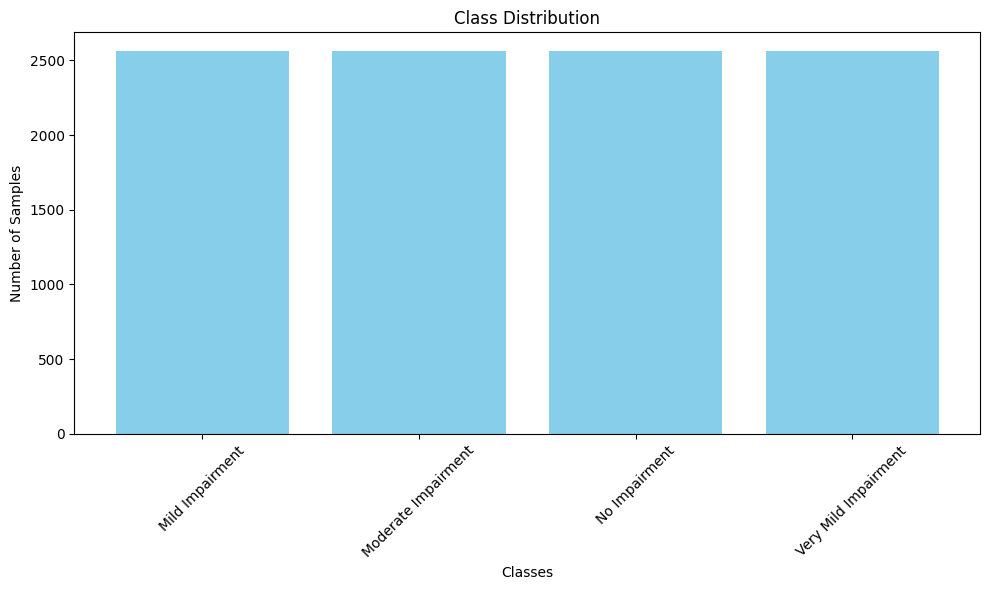

In [123]:
import os
import matplotlib.pyplot as plt

# Define the directory path containing subdirectories of classes
directory_path = train_dir

# Initialize a dictionary to store counts for each class
class_counts = {}

# Iterate through subdirectories
for class_name in os.listdir(directory_path):
    class_dir = os.path.join(directory_path, class_name)
    
    # Check if it's a directory
    if os.path.isdir(class_dir):
        # Count the number of files in each subdirectory (class)
        file_count = len(os.listdir(class_dir))
        class_counts[class_name] = file_count

# Calculate the total number of samples and identify the majority and minority classes
total_samples = sum(class_counts.values())
majority_class = max(class_counts, key=class_counts.get)
minority_class = min(class_counts, key=class_counts.get)

# Calculate class imbalance ratio
imbalance_ratio = total_samples / class_counts[minority_class]

# Create lists for plotting
class_names = list(class_counts.keys())
sample_counts = list(class_counts.values())

# Plotting the class distribution
plt.figure(figsize=(10, 6))
plt.bar(class_names, sample_counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()

# Display class imbalance ratio
print("Class Distribution:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count} samples")

print("\nClass Imbalance Ratio:")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")

plt.show()


In [127]:
def eval_model(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
  """ Returns a dictionary containing the results of model predicting on Data Loader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):
      # Send data to target device
      X, y = X.to(device), y.to(device)
      model = model.to(device)
      # Make predictions
      y_pred = model(X)

      # Calculate loss and accuracy per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true=y,
                        y_pred=y_pred.argmax(dim=1))

    # Scale loss and accuracy to find the average loss/accuracy per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"Model_Name": model.__class__.__name__, # only works when model was created with a class
          "Model_Loss": loss.item(),
          "Model_Acc": acc}

In [128]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [129]:
import random
import textwrap

from pathlib import Path

from typing import List, Tuple
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# 1. Take in a trained model
def pred_and_plot_image(model: torch.nn.Module,
                        subplot: Tuple[int, int, int],
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):
  # 2. Open the image with PIL
  def pil_load(path):
    with open(path, "rb") as f:
      img = Image.open(f)
      return img.convert('RGB')
  
  img = pil_load(image_path)

  # 3. Create a transform if one doesn't exist
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize(size=(image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

  ### Predict on image ###
  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn the model to eval mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform the target image and dimension
    transformed_image = image_transform(img).unsqueeze(dim=0) # add batch_size to the dimension -> [batch_size, color_channel, height, width]

    # 7. Make a prediction on the transformed image by passing it to the model and send it to the target device
    target_image_pred = model(transformed_image.to(device))

    # 8. Convert output logits into pred probs
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert pred probs into pred labels
    target_image_pred_labels = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot the image with predicted label and probs
    plt.subplot(*subplot)
    plt.imshow(img)
    title_text = f"Ground Truth: {image_path.parent.stem} | Pred: {class_names[target_image_pred_labels]} | Prob: {target_image_pred_probs.max():.3f}"
    if image_path.parent.stem == class_names[target_image_pred_labels]:
      plt.title(title_text, color='green')
    else:
      plt.title(title_text, color='red')
    plt.title("\n".join(textwrap.wrap(title_text, width=27)))
    plt.axis(False)

In [130]:
# Instantiate the ViT Model
ViTModel = model_builder.ViT(num_classes=len(class_names)).to(device)
ViTModel

# Define the optimizer
optimizer = torch.optim.Adam(params=ViTModel.parameters(), lr=1e-2)

# Define the loss function
loss_fn = torch.nn.CrossEntropyLoss()

helper_functions.set_seeds()

# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

results = engine.train(
    model=ViTModel,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    scheduler=None,
    loss_fn=loss_fn,
    epochs=10,
    device=device,
)


 10%|█         | 1/10 [04:02<36:18, 242.00s/it]

Epoch: 1 | Train Loss:1.4524 | Train Accuracy: 0.37% | Test Loss: 1.3976 | Test Accuracy: 0.19%


 20%|██        | 2/10 [08:07<32:30, 243.76s/it]

Epoch: 2 | Train Loss:0.7469 | Train Accuracy: 0.64% | Test Loss: 1.0913 | Test Accuracy: 0.35%


 30%|███       | 3/10 [12:06<28:13, 241.86s/it]

Epoch: 3 | Train Loss:0.6511 | Train Accuracy: 0.68% | Test Loss: 1.0612 | Test Accuracy: 0.50%


 40%|████      | 4/10 [16:11<24:19, 243.22s/it]

Epoch: 4 | Train Loss:0.6173 | Train Accuracy: 0.70% | Test Loss: 1.0486 | Test Accuracy: 0.50%


 50%|█████     | 5/10 [20:17<20:20, 244.13s/it]

Epoch: 5 | Train Loss:0.5880 | Train Accuracy: 0.71% | Test Loss: 1.0330 | Test Accuracy: 0.50%


 60%|██████    | 6/10 [24:28<16:25, 246.30s/it]

Epoch: 6 | Train Loss:0.5754 | Train Accuracy: 0.72% | Test Loss: 1.1366 | Test Accuracy: 0.50%


 70%|███████   | 7/10 [28:34<12:19, 246.34s/it]

Epoch: 7 | Train Loss:0.5786 | Train Accuracy: 0.71% | Test Loss: 1.0626 | Test Accuracy: 0.35%


 80%|████████  | 8/10 [32:38<08:11, 245.58s/it]

Epoch: 8 | Train Loss:0.5953 | Train Accuracy: 0.71% | Test Loss: 1.0741 | Test Accuracy: 0.35%


 90%|█████████ | 9/10 [36:35<04:02, 242.85s/it]

Epoch: 9 | Train Loss:0.8939 | Train Accuracy: 0.57% | Test Loss: 1.3561 | Test Accuracy: 0.50%


100%|██████████| 10/10 [40:33<00:00, 243.38s/it]

Epoch: 10 | Train Loss:0.9834 | Train Accuracy: 0.52% | Test Loss: 1.0750 | Test Accuracy: 0.50%


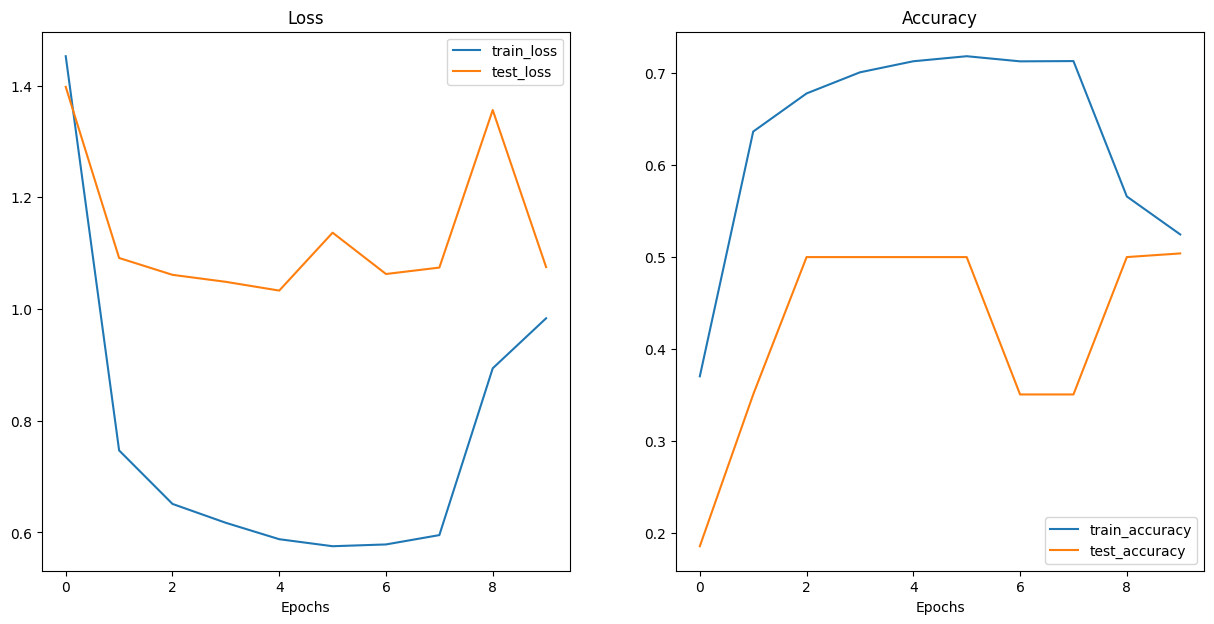

In [131]:
helper_functions.plot_loss_curves(results=results)

In [132]:
model_results_1 = eval_model(ViTModel, test_dataloader, loss_fn, accuracy_fn)

100%|██████████| 40/40 [00:09<00:00,  4.06it/s]


In [133]:
model_results_1

{'Model_Name': 'ViT',
 'Model_Loss': 1.0750213861465454,
 'Model_Acc': 50.39566532258065}

In [134]:
import random
import numpy as np

from pathlib import Path

def plot_random_images(model: torch.nn.Module,
                       num_images_to_get: int = 30):
  image_path_list = list(Path(test_dir).glob("*/*"))
  image_path_sample = random.sample(population=image_path_list, k=num_images_to_get)
  
  # Setup subplots
  num_rows = int(np.ceil(num_images_to_get / 5))
  fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
  ax = ax.flatten()


  for i, image_path in enumerate(image_path_sample):
    pred_and_plot_image(model=model,
                        subplot=(num_rows, 5, i+1),
                        image_path=image_path,
                        class_names=class_names,
                        transform=simple_transform,
                        device=device)

  plt.subplots_adjust(wspace=1)
  plt.show()

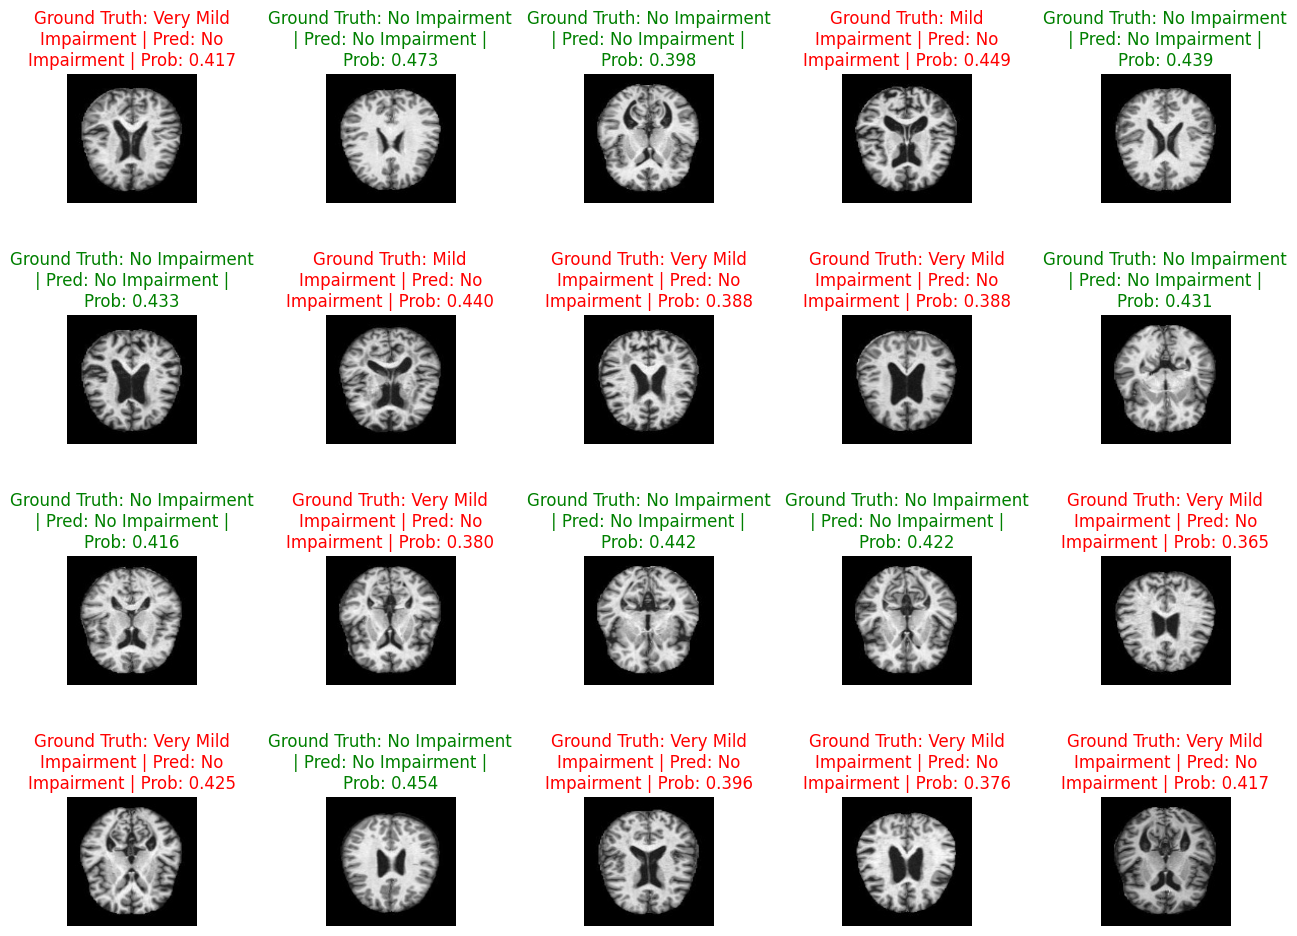

In [136]:
plot_random_images(ViTModel, 20)

In [137]:
utils.save_model(model=ViTModel,
           target_dir='models',
           model_name='ViTMode10E.pth',)

[INFO] Saving model to: models\ViTMode10E.pth


## Transfer Learning

In [138]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
weights

ViT_B_16_Weights.IMAGENET1K_V1

In [139]:
auto_transform = weights.transforms()
auto_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [140]:
ViTModelTransfer = torchvision.models.vit_b_16(weights=weights)
ViTModelTransfer 

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [141]:
from torchinfo import summary

summary(model=ViTModelTransfer,
        input_size=[1, 3, 224, 224],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 197, 768

In [142]:
for param in ViTModelTransfer.parameters():
  param.requires_grad = False

In [143]:
import torch
from torch import nn

helper_functions.set_seeds()

ViTModelTransfer.heads = nn.Linear(in_features=768, out_features=len(class_names))

In [144]:
summary(model=ViTModelTransfer,
        input_size=[1, 3, 224, 224],
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 4]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [145]:
# Setup new test and train dataloader with auto transform

BATCH_SIZE=32

train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     train_transform=auto_transform,
                                                                                                     transform=auto_transform,
                                                                                                     batch_size=BATCH_SIZE)

In [146]:
len(train_dataloader_pretrained), len(test_dataloader_pretrained), class_names, device

(320,
 40,
 ['Mild Impairment',
  'Moderate Impairment',
  'No Impairment',
  'Very Mild Impairment'],
 'cuda')

In [147]:
helper_functions.set_seeds()

# Create device agnostic code
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

# Send model to target device before training
ViTModelTransfer.to(device)

# Set optimizer and loss function
optimizer = torch.optim.Adam(params=ViTModelTransfer.parameters(), lr=1e-2)

loss_fn = nn.CrossEntropyLoss()

results_transfer = engine.train(model=ViTModelTransfer,
                                train_dataloader=train_dataloader_pretrained,
                                test_dataloader=test_dataloader_pretrained,
                                optimizer=optimizer,
                                scheduler=None,
                                loss_fn=loss_fn,
                                epochs=10,
                                device=device,
)

 10%|█         | 1/10 [02:10<19:30, 130.06s/it]

Epoch: 1 | Train Loss:0.7111 | Train Accuracy: 0.71% | Test Loss: 1.1834 | Test Accuracy: 0.51%


 20%|██        | 2/10 [04:19<17:18, 129.81s/it]

Epoch: 2 | Train Loss:0.5269 | Train Accuracy: 0.78% | Test Loss: 0.7951 | Test Accuracy: 0.63%


 30%|███       | 3/10 [06:28<15:04, 129.28s/it]

Epoch: 3 | Train Loss:0.4938 | Train Accuracy: 0.80% | Test Loss: 0.8754 | Test Accuracy: 0.65%


 40%|████      | 4/10 [08:38<12:57, 129.54s/it]

Epoch: 4 | Train Loss:0.4682 | Train Accuracy: 0.81% | Test Loss: 1.0441 | Test Accuracy: 0.59%


 50%|█████     | 5/10 [10:48<10:48, 129.72s/it]

Epoch: 5 | Train Loss:0.4607 | Train Accuracy: 0.81% | Test Loss: 0.9314 | Test Accuracy: 0.63%


 60%|██████    | 6/10 [12:58<08:39, 129.85s/it]

Epoch: 6 | Train Loss:0.4698 | Train Accuracy: 0.81% | Test Loss: 0.7682 | Test Accuracy: 0.66%


 70%|███████   | 7/10 [15:06<06:28, 129.34s/it]

Epoch: 7 | Train Loss:0.4553 | Train Accuracy: 0.82% | Test Loss: 0.7598 | Test Accuracy: 0.66%


 80%|████████  | 8/10 [17:13<04:16, 128.40s/it]

Epoch: 8 | Train Loss:0.4139 | Train Accuracy: 0.83% | Test Loss: 0.7780 | Test Accuracy: 0.67%


 90%|█████████ | 9/10 [19:19<02:07, 127.77s/it]

Epoch: 9 | Train Loss:0.4131 | Train Accuracy: 0.84% | Test Loss: 0.7254 | Test Accuracy: 0.68%


100%|██████████| 10/10 [21:25<00:00, 128.59s/it]

Epoch: 10 | Train Loss:0.4318 | Train Accuracy: 0.83% | Test Loss: 0.8314 | Test Accuracy: 0.66%


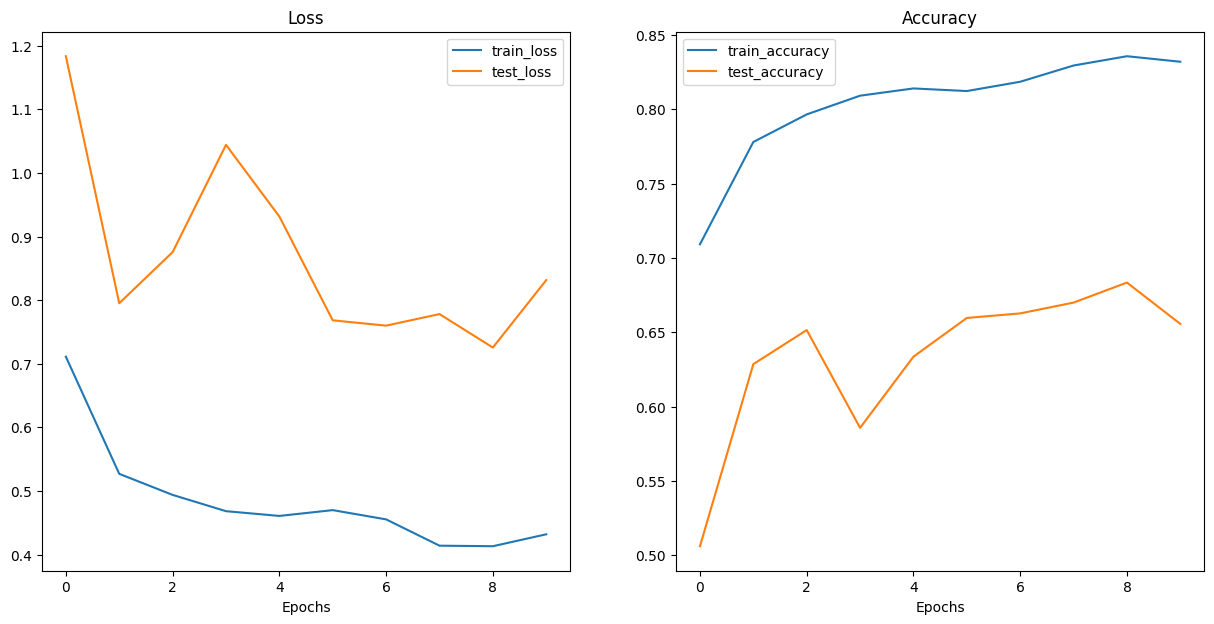

In [148]:
helper_functions.plot_loss_curves(results=results_transfer)

In [149]:
utils.save_model(model=ViTModelTransfer,
                 target_dir='models',
                 model_name='ViTModelTransferLearning10E.pth',)

[INFO] Saving model to: models\ViTModelTransferLearning10E.pth


In [150]:
model_results_2 = eval_model(ViTModelTransfer, test_dataloader_pretrained, loss_fn, accuracy_fn)

100%|██████████| 40/40 [00:10<00:00,  3.70it/s]


In [152]:
model_results_2

{'Model_Name': 'VisionTransformer',
 'Model_Loss': 0.8314420580863953,
 'Model_Acc': 65.55947580645162}

In [153]:
import random
import numpy as np

from pathlib import Path

def plot_random_images(model: torch.nn.Module,
                       num_images_to_get: int = 30):
  image_path_list = list(Path(test_dir).glob("*/*"))
  image_path_sample = random.sample(population=image_path_list, k=num_images_to_get)
  
  # Setup subplots
  num_rows = int(np.ceil(num_images_to_get / 5))
  fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
  ax = ax.flatten()


  for i, image_path in enumerate(image_path_sample):
    pred_and_plot_image(model=model,
                        subplot=(num_rows, 5, i+1),
                        image_path=image_path,
                        class_names=class_names,
                        transform=auto_transform,
                        device=device)

  plt.subplots_adjust(wspace=1)
  plt.show()

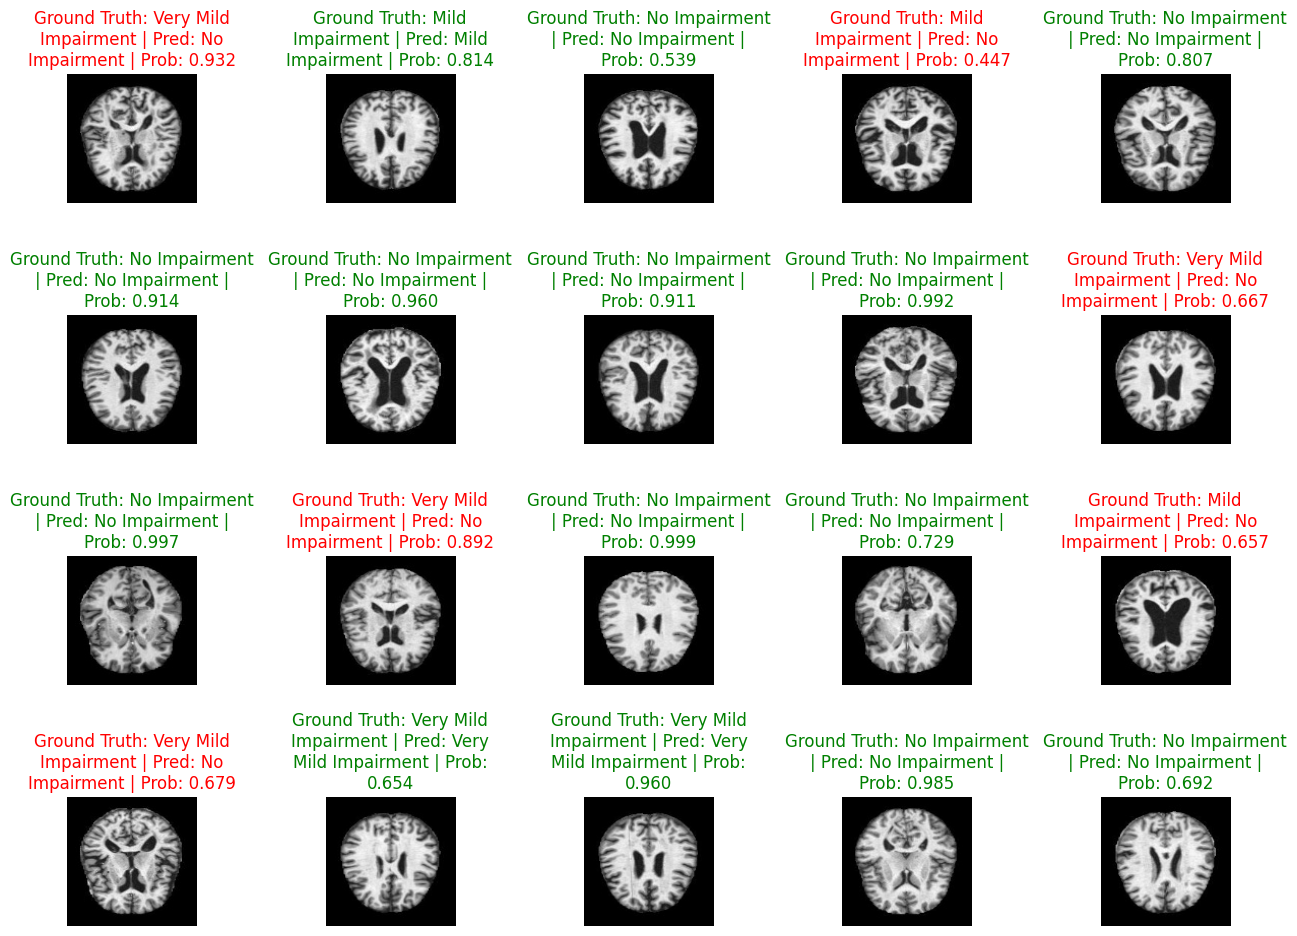

In [154]:
plot_random_images(ViTModelTransfer,20)